In [1]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# pip install torchmetrics==1.2.0 pandas==2.1.4 numpy==1.26.4

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util
import pickle

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density, Density_Plot_of_AUC_Values, Confusion_Matrix_plot
from utils.tools import get_data_value_range,set_seed,get_vram_usage

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [2]:
# best_weight_path = './inference/results_GDSC/BF2_test_loss0.0699297_BestValEpo13_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse/'
# best_weight_path = './inference/results_GDSC/BF2_MAE_test_loss0.0702329_BestValEpo60_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse/'
# best_weight_path = './inference/results_GDSC/BF3_BCE_test_loss0.3974576_BestValEpo41_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight_path = './inference/results_GDSC/BF2_MAE_test_loss0.0750375_BestValEpo107_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse/'
# best_weight_path = './inference/results_GDSC/BF0_BCE_test_loss0.4135855_BestValEpo156_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse_nlayer1/'

In [3]:
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset
drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
AUC_df_path_numerical = "../data/DAPL/share/gdsc1+2_ccle_AUC_sorted.csv" # gdsc1+2_ccle_z-score　gdsc1+2_ccle_AUC
AUC_df_path = "../data/DAPL/share/gdsc1+2_ccle_AUC_sorted_binary(median).csv"

omics_files = {
    'Mut': "",
    'Exp': "../data/DAPL/share/ccle_uq1000_feature_sorted.csv", # "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[128,32],'Exp':[128,32], # Dr.Chiu:exp[500,200,50] [1000,100,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "",
                                  'Exp': "./results/Encoder_tcga_exp_128_32_best_loss_0.2182988.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DCSA_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 5
include_omics = ['Exp']
deconfound_EXPembedding = True # False True
if deconfound_EXPembedding is True:
    DA_Folder = "VAE"
    omics_files['Exp'] = f"../data/DAPL/share/pretrain/{DA_Folder}/ccle_latent_results.pkl" #
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = False
n_layer=1
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
if model_name == "Omics_DCSA_Model":
    drug_encode_dims =[(max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*128), 700, 70, 1] #
    dense_layer_dim = None
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 500
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 1
continuous = True
learning_rate=1e-06

criterion = Custom_LossFunction(loss_type="MAE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
if criterion.loss_type == "BCE":
    metrics_type_set = ["Accuracy","AUROC", "AUPRC", "Sensitivity","Specificity", "Precision", "F1"] 
else:
    metrics_type_set = ["MSE", "R^2"] #"MSE","MAE"  None
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n n_layer ={n_layer}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)


drug_encode_dims [7064, 700, 70, 1]
dense_layer_dim None


In [4]:
# 檢查exp和AUC的samples是否一致
if deconfound_EXPembedding is True:
    with open(omics_files['Exp'], 'rb') as f:
        latent_dict = pickle.load(f)
        exp_df = pd.DataFrame(latent_dict).T
else:
    exp_df = pd.read_csv(omics_files["Exp"], sep=',', index_col=0)
AUC_df_numerical = pd.read_csv(AUC_df_path_numerical, sep=',', index_col=0)
print(f"exp_df samples: {len(exp_df.index)} , AUC_df_numerical samples: {len(AUC_df_numerical.index)}")
matched_samples = sorted(set(AUC_df_numerical.index) & set(exp_df.index))
print(f"matched samples: {len(matched_samples)}")

exp_df samples: 1305 , AUC_df_numerical samples: 966
matched samples: 680


In [5]:
# 讀取omics資料
set_seed(seed)
for omic_type in include_omics:
    if deconfound_EXPembedding is True:
        omics_data_dict["Exp"] = exp_df.loc[matched_samples]
        print(f"deconfound_EXPembedding is True {deconfound_EXPembedding}")
    else:
        print(f"deconfound_EXPembedding is False {deconfound_EXPembedding}")
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0)
        
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns).loc[matched_samples]
    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
        
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

del exp_df
gc.collect()

deconfound_EXPembedding is True True
Exp tensor shape: torch.Size([680, 32])
Exp num_features 32


18

In [6]:
drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
print(drug_df.shape)
print("AUC_df_numerical",AUC_df_numerical.shape)
# matched AUCfile and omics_data samples
AUC_df_numerical= (AUC_df_numerical.loc[matched_samples])
print("AUC_df_numerical match samples",AUC_df_numerical.shape)
median_value = np.nanmedian(AUC_df_numerical.values)  # Directly calculate median, ignoring NaNs
print("median_value",median_value)    
if criterion.loss_type == "BCE":
    AUC_df = pd.read_csv(AUC_df_path, sep=',', index_col=0).loc[matched_samples] # binary data
    print("AUC_df",AUC_df.shape)
else:
    AUC_df = AUC_df_numerical.copy()
del AUC_df_numerical

if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)

(393, 9)
AUC_df_numerical (966, 393)
AUC_df_numerical match samples (680, 393)
median_value 0.927835


In [7]:
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)

if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [8]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
AUC_df = AUC_df.apply(pd.to_numeric, errors='coerce')# Ensure all values are numeric, coercing non-numeric ones to NaN
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  680 393
torch.Size([680, 393])
['C[C@H]1C', '/C', '=C', '\\C(=O)', '[C@H](', '[C@H](C', '/C', '=C', '/C', '2=C(C', '(=CC', '(=C', '2)', 'OC)', 'O)', 'C(=O)O', '1)', 'O)', 'O']


In [9]:
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')


id_unrepeat_train (544,)
id_unrepeat_val (68,)
id_unrepeat_test (68,)
id_unrepeat_train_val (612,)
id_test.shape (26724,)


In [10]:
print(id_test[:10])

[1965 1966 1967 1968 1969 1970 1971 1972 1973 1974]


In [11]:
#create dataset
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #, num_workers=4, pin_memory=True
#create whole dataset
whole_loader = DataLoader(dataset, batch_size=6000, shuffle=False)

self.num_drugs 393


In [12]:
%%time
# inference

set_seed(seed)
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer, deconfound_EXPembedding, TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer, deconfound_EXPembedding, TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)

model.to(device=device)
best_weight = best_weight_path + "BestValWeight.pt"

# load Drug_Cell_SelfAttention to Drug_Cell_SelfAttention.layers.0
def rename_keys_for_layer0(state_dict):
    new_state_dict = {}
    for key in state_dict:
        if key.startswith("Drug_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_SelfAttention.'
            new_key = key.replace("Drug_SelfAttention.", "Drug_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        elif key.startswith("Drug_Cell_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_Cell_SelfAttention.'
            new_key = key.replace("Drug_Cell_SelfAttention.", "Drug_Cell_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        else:
            new_state_dict[key] = state_dict[key]
    return new_state_dict
best_weight = torch.load(best_weight)

# if n_layer == 1:
#     best_weight = rename_keys_for_layer0(best_weight)
model.load_state_dict(best_weight) # model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 _ ,_,
 eval_outputs_before_final_activation_list, 
 mean_batch_eval_lossWOpenalty)  = evaluation(model, None,None,
                                             criterion, whole_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference') # whole_loader




 Drug_SelfAttention is not applied 

CPU times: user 10.5 s, sys: 333 ms, total: 10.8 s
Wall time: 11.5 s


In [13]:
torch.cat(eval_outputs).shape

torch.Size([230263])

In [137]:
predAUCwithUnknownGT_list = np.concatenate(predAUCwithUnknownGT)
print(predAUCwithUnknownGT_list.shape)
predAUCmatrix = predAUCwithUnknownGT_list.reshape(num_ccl, num_drug) # numpy.ndarray

predAUCmatrix_df = pd.DataFrame(predAUCmatrix, columns=AUC_df.columns, index=AUC_df.index)
# Output to CSV
predAUCmatrix_df.to_csv(best_weight_path+'predicted AUC values with UnknownGroundTruth samples.csv')
print("CSV file has been saved.")

(267240,)
CSV file has been saved.


In [14]:
if criterion.loss_type == "BCE":
    print("mean_batch_eval_lossWOpenalty",mean_batch_eval_lossWOpenalty)
    eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)
    print(eval_metrics)
    (eval_cm , eval_GT_0_count, eval_GT_1_count, 
        eval_pred_binary_0_count, eval_pred_binary_1_count) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)
    print("eval_cm",eval_cm)
    print("eval_GT_0_count",eval_GT_0_count)
    print("eval_GT_1_count",eval_GT_1_count)
    print("eval_pred_binary_0_count",eval_pred_binary_0_count)
    print("eval_pred_binary_1_count",eval_pred_binary_1_count)
    cm_datas = [(eval_cm, 'whole', 'Blues')]
    Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None)

In [ ]:
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/TCGA/sorafenib_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)
    TCGAexp_df = pd.DataFrame(latent_dict).T

In [ ]:
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/ccle_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)
    CCLEexp_df = pd.DataFrame(latent_dict).T


In [109]:
np.concatenate(CCLEexp_df.values)

array([ 1.69142168e-05, -5.95177480e-05, -4.42806959e-06, ...,
       -8.44531496e-06,  1.07408923e-05, -3.49500624e-07])

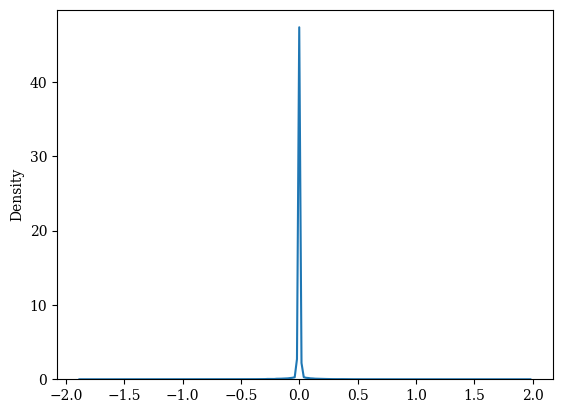

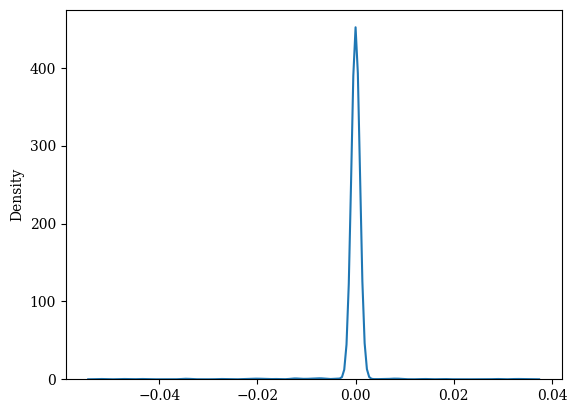

In [116]:
sns.kdeplot(np.concatenate(CCLEexp_df.values).tolist())
plt.show()
sns.kdeplot(np.concatenate(TCGAexp_df.values).tolist())
plt.show()

In [ ]:
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/TCGA/temozolomide_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)
    TCGAexp_df = pd.DataFrame(latent_dict).T
get_data_value_range(CCLEexp_df.values,"CCLE deconfound latent space")
get_data_value_range(TCGAexp_df.values,"TCGA deconfound latent space")

CCLE deconfound latent space : 
Range: 3.81821430
Minimum: -1.86012816
Maximum: 1.95808613
Mean: -0.00094057
Median: -0.00000048
Standard Deviation: 0.06501474
Skewness: -1.74072191
binary data:False
-------------------------------------
TCGA deconfound latent space : 
Range: 0.00036888
Minimum: -0.00022033
Maximum: 0.00014855
Mean: -0.00000007
Median: -0.00000098
Standard Deviation: 0.00002906
Skewness: -0.30188849
binary data:False
-------------------------------------


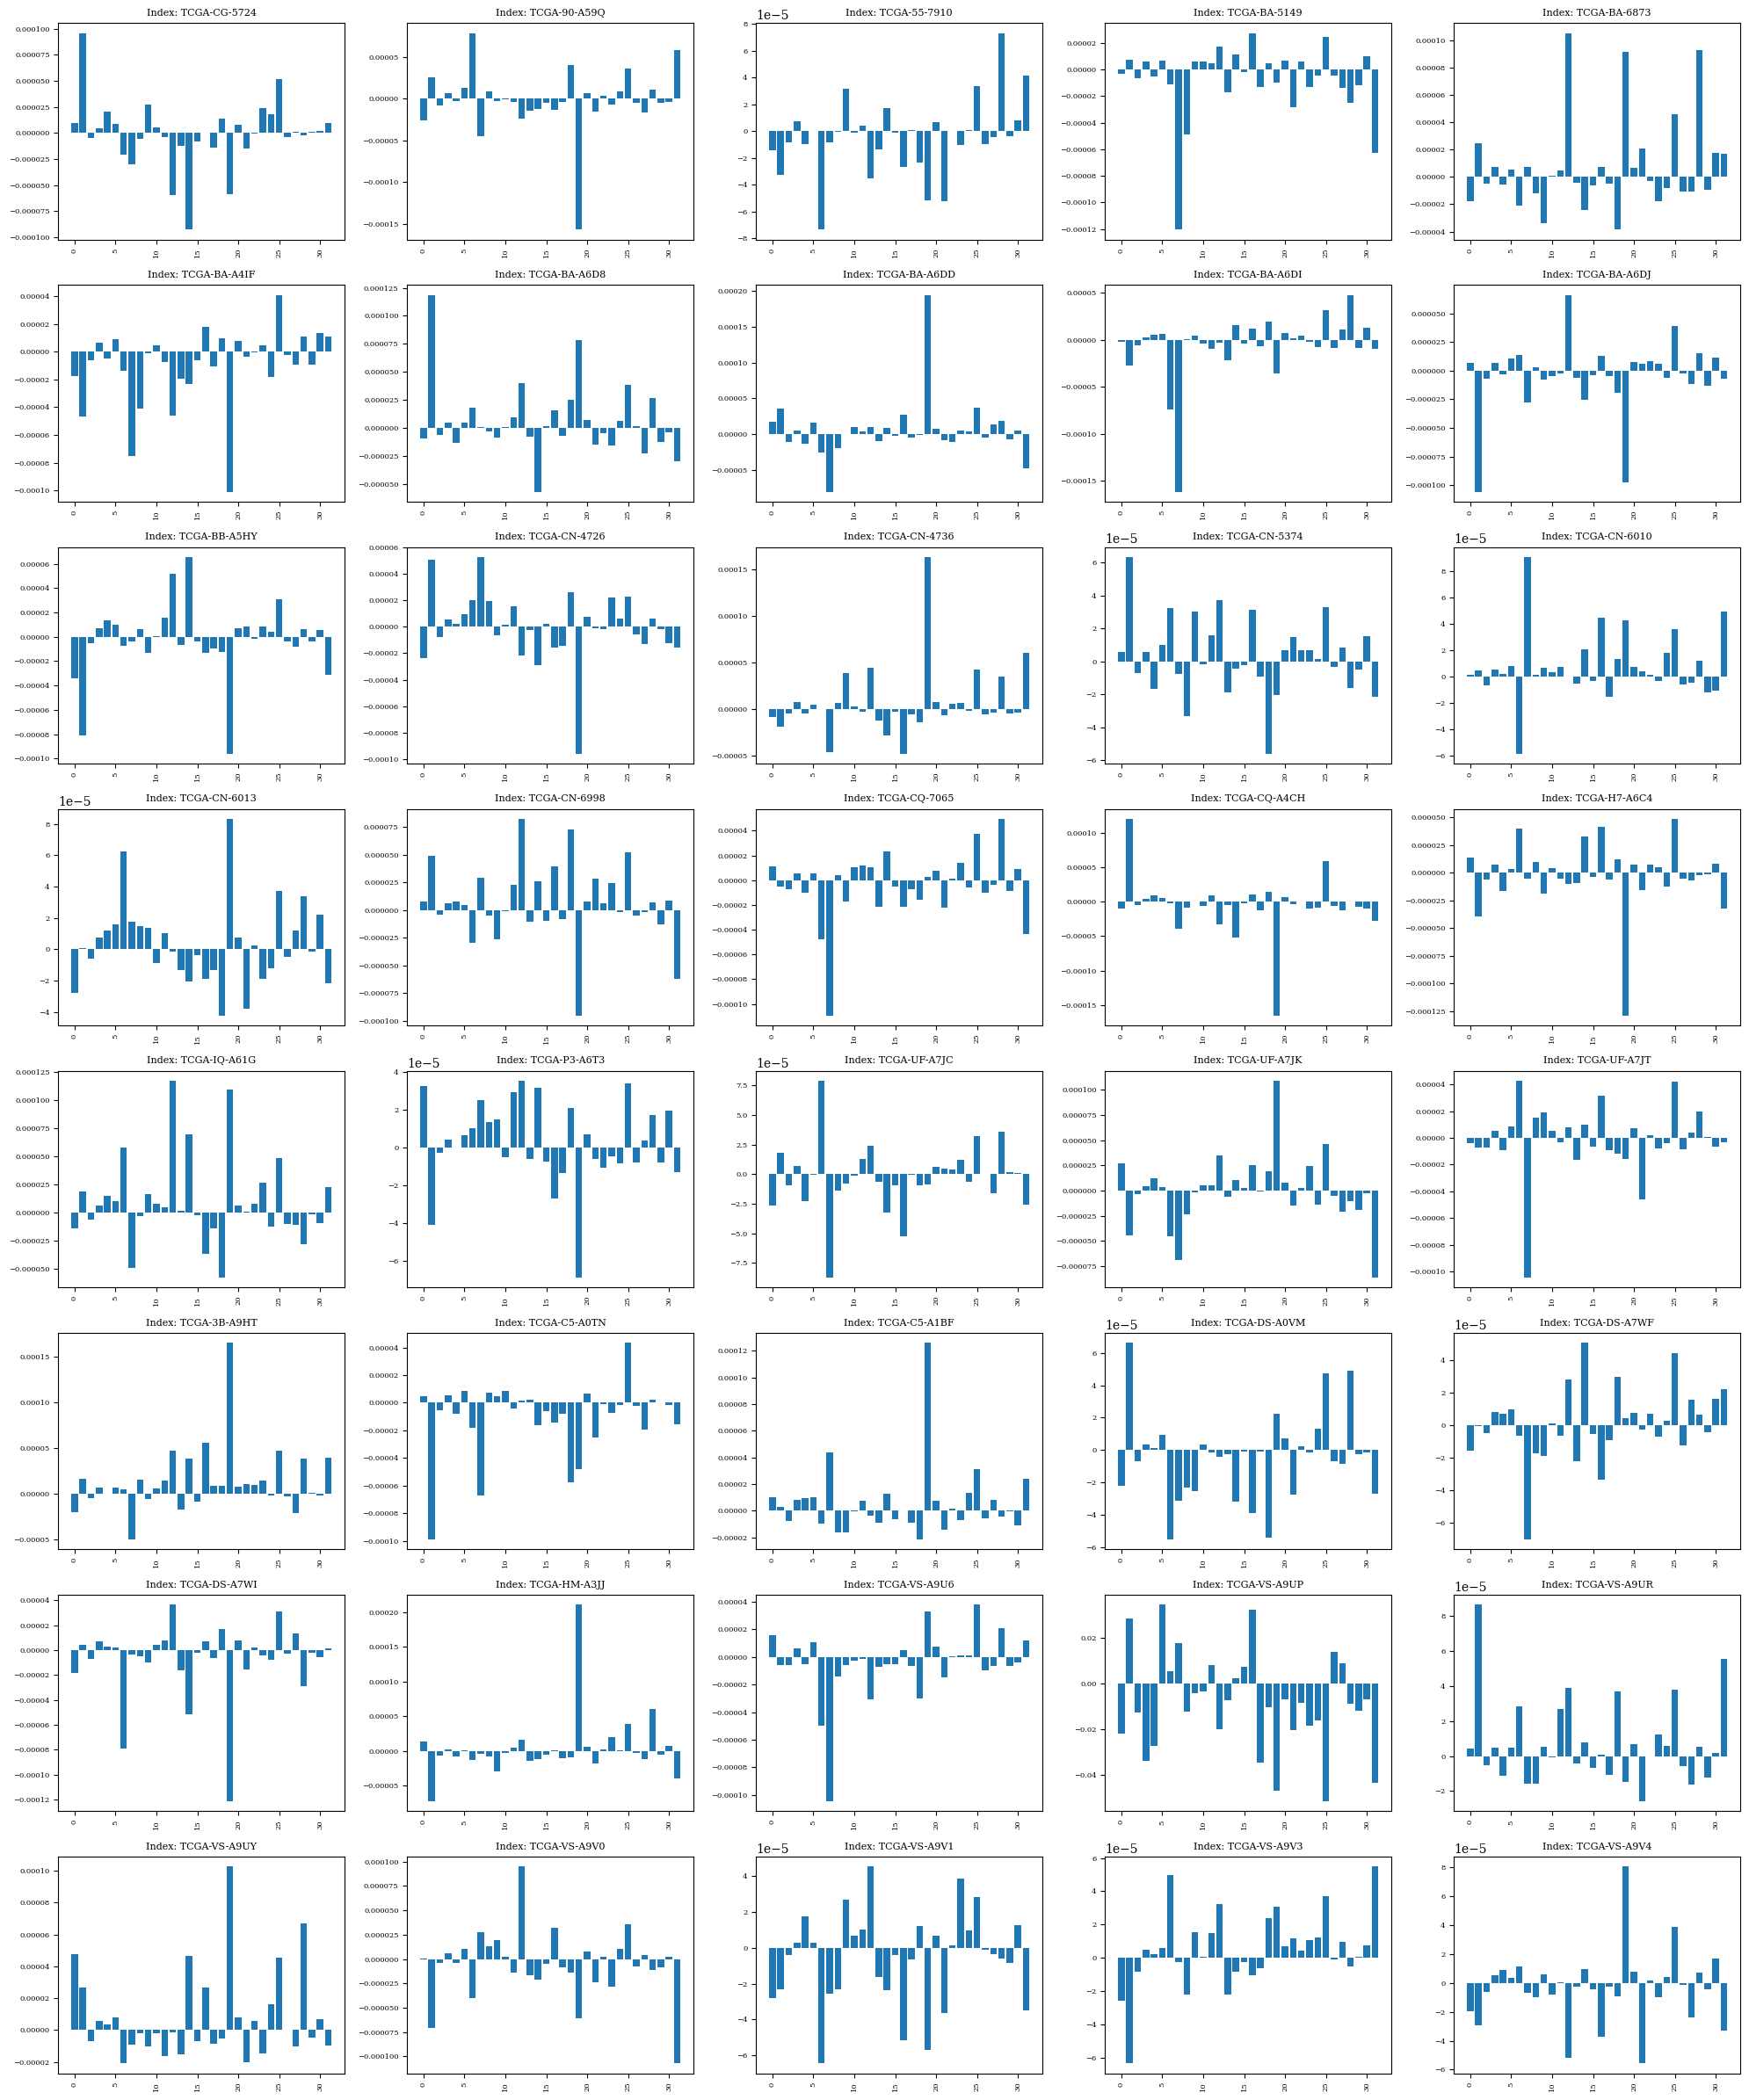

In [ ]:
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/TCGA/temozolomide_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)
    TCGAexp_df = pd.DataFrame(latent_dict).T
# plot Expression distribution of each TCGA sample
import math
n_rows = len(TCGAexp_df)
n_cols = 5  # 5 subplots per row
n_fig_rows = math.ceil(n_rows / n_cols)
fig, axes = plt.subplots(n_fig_rows, n_cols, figsize=(n_cols * 4, n_fig_rows * 3))
# Flatten axes for easy iteration
axes = axes.flatten()
for i, (index, row) in enumerate(TCGAexp_df.iterrows()):
    axes[i].bar(TCGAexp_df.columns, row.values)
    axes[i].set_title(f"Index: {index}", fontsize=8)
    axes[i].tick_params(axis='x', labelrotation=90, labelsize=6)
    axes[i].tick_params(axis='y', labelsize=6)
# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

## TCGA inference, PDX inference

TCGAexp cisplatindata (40, 32)
label_df cisplatindata (40, 1)
Exp tensor shape: torch.Size([40, 32])
Exp num_features 32
              PATHWAY_NAME                                           synonyms  \
DRUG_NAME                                                                       
cisplatin  DNA replication  cis-Diammineplatinum(II) dichloride, Platinol,...   

              pathway_name          targets  pubchem Dataset       name  \
DRUG_NAME                                                                 
cisplatin  DNA replication  DNA crosslinker    84691   GDSC2  cisplatin   

                           SMILES  
DRUG_NAME                          
cisplatin  N.N.[Cl-].[Cl-].[Pt+2]  
drug_smiles DRUG_NAME
cisplatin    N.N.[Cl-].[Cl-].[Pt+2]
Name: SMILES, dtype: object
num_ccl,num_drug:  40 1
torch.Size([1, 2, 50])
torch.Size([40, 1, 1])
weighted_threshold: None
self.num_drugs 1
eval_targets
 [tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        

/tmp/ipykernel_23619/542969977.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


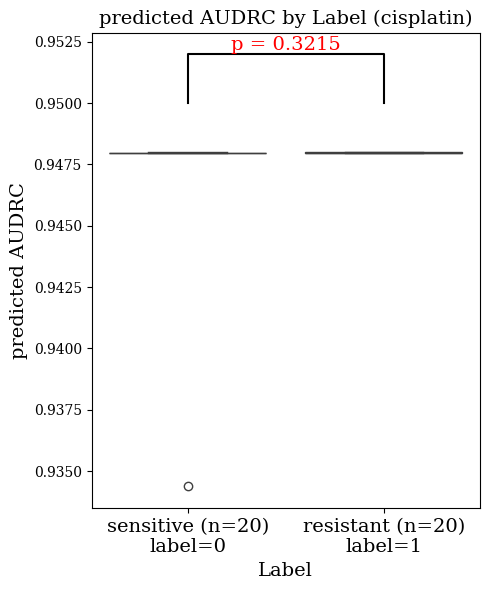

cisplatin
  'AUROC': 0.6600
  'AUPRC': 0.7476
  'MAE': 0.4997

TCGAexp 5-fluorouracildata (21, 32)
label_df 5-fluorouracildata (21, 1)
Exp tensor shape: torch.Size([21, 32])
Exp num_features 32
               PATHWAY_NAME synonyms pathway_name                     targets  \
DRUG_NAME                                                                       
5-fluorouracil        Other     5-FU        Other  Antimetabolite (DNA & RNA)   

                pubchem Dataset            name                SMILES  
DRUG_NAME                                                              
5-fluorouracil     3385   GDSC2  5-fluorouracil  C1=C(C(=O)NC(=O)N1)F  
drug_smiles DRUG_NAME
5-fluorouracil    C1=C(C(=O)NC(=O)N1)F
Name: SMILES, dtype: object
num_ccl,num_drug:  21 1
torch.Size([1, 2, 50])
torch.Size([21, 1, 1])
weighted_threshold: None
self.num_drugs 1
eval_targets
 [tensor([1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 0.], device='cuda:0')]
eval_output

/tmp/ipykernel_23619/542969977.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


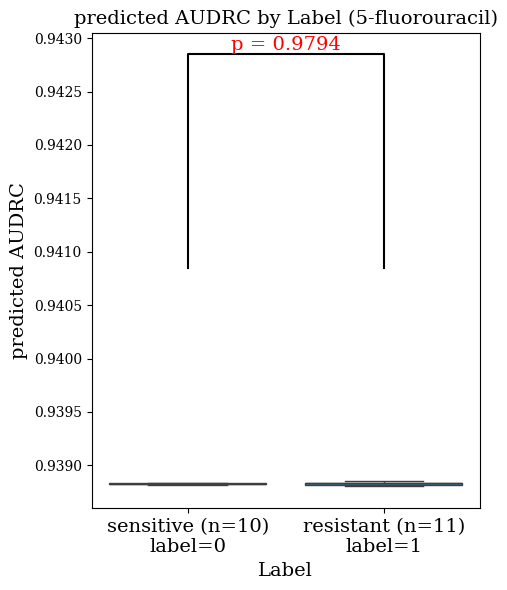

cisplatin
  'AUROC': 0.6600
  'AUPRC': 0.7476
  'MAE': 0.4997

5-fluorouracil
  'AUROC': 0.4591
  'AUPRC': 0.6004
  'MAE': 0.4791

TCGAexp gemcitabinedata (46, 32)
label_df gemcitabinedata (46, 1)
Exp tensor shape: torch.Size([46, 32])
Exp num_features 32
                PATHWAY_NAME           synonyms     pathway_name  \
DRUG_NAME                                                          
gemcitabine  DNA replication  Gemzar, LY-188011  DNA replication   

                               targets  pubchem Dataset         name  \
DRUG_NAME                                                              
gemcitabine  Pyrimidine antimetabolite    60750   GDSC2  gemcitabine   

                                                        SMILES  
DRUG_NAME                                                       
gemcitabine  C1=CN(C(=O)N=C1N)[C@H]2C([C@@H]([C@H](O2)CO)O)...  
drug_smiles DRUG_NAME
gemcitabine    C1=CN(C(=O)N=C1N)[C@H]2C([C@@H]([C@H](O2)CO)O)...
Name: SMILES, dtype: object
num_ccl,num_

/tmp/ipykernel_23619/542969977.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


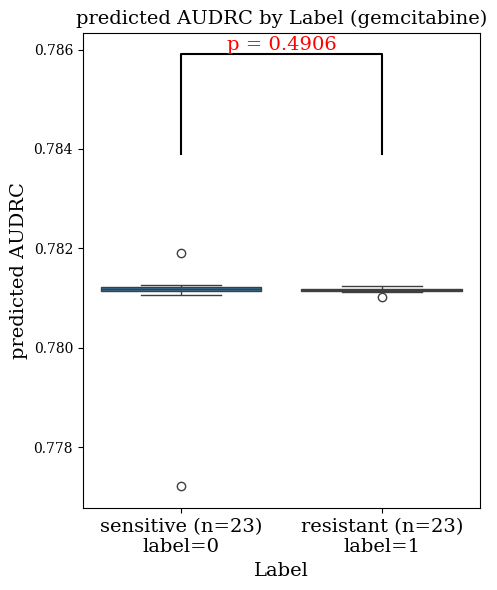

cisplatin
  'AUROC': 0.6600
  'AUPRC': 0.7476
  'MAE': 0.4997

5-fluorouracil
  'AUROC': 0.4591
  'AUPRC': 0.6004
  'MAE': 0.4791

gemcitabine
  'AUROC': 0.3724
  'AUPRC': 0.4184
  'MAE': 0.4999

TCGAexp sorafenibdata (26, 32)
label_df sorafenibdata (26, 1)
Exp tensor shape: torch.Size([26, 32])
Exp num_features 32
             PATHWAY_NAME                           synonyms    pathway_name  \
DRUG_NAME                                                                      
sorafenib  Other, kinases  Nexavar, 284461-73-0, BAY 43-9006  Other, kinases   

                          targets  pubchem Dataset       name  \
DRUG_NAME                                                       
sorafenib  PDGFR, KIT, VEGFR, RAF   216239   GDSC2  sorafenib   

                                                      SMILES  
DRUG_NAME                                                     
sorafenib  CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...  
drug_smiles DRUG_NAME
sorafenib    CNC(=O)C1=NC=CC(=C1)OC

/tmp/ipykernel_23619/542969977.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


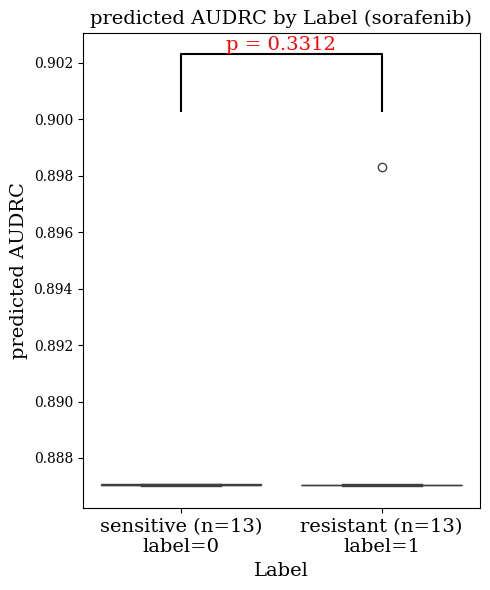

cisplatin
  'AUROC': 0.6600
  'AUPRC': 0.7476
  'MAE': 0.4997

5-fluorouracil
  'AUROC': 0.4591
  'AUPRC': 0.6004
  'MAE': 0.4791

gemcitabine
  'AUROC': 0.3724
  'AUPRC': 0.4184
  'MAE': 0.4999

sorafenib
  'AUROC': 0.4793
  'AUPRC': 0.5672
  'MAE': 0.4996

TCGAexp temozolomidedata (46, 32)
label_df temozolomidedata (46, 1)
Exp tensor shape: torch.Size([46, 32])
Exp num_features 32
                 PATHWAY_NAME                              synonyms  \
DRUG_NAME                                                             
temozolomide  DNA replication  Temodar, Temodal, M-39831, SCH 52365   

                 pathway_name               targets  pubchem Dataset  \
DRUG_NAME                                                              
temozolomide  DNA replication  DNA alkylating agent     5394   GDSC2   

                      name                         SMILES  
DRUG_NAME                                                  
temozolomide  temozolomide  CN1C(=O)N2C=NC(=C2N=N1)C(=O)N  
dru

/tmp/ipykernel_23619/542969977.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


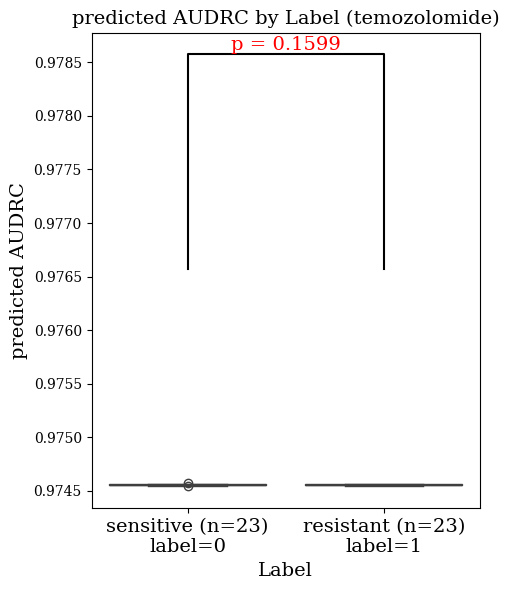

cisplatin
  'AUROC': 0.6600
  'AUPRC': 0.7476
  'MAE': 0.4997

5-fluorouracil
  'AUROC': 0.4591
  'AUPRC': 0.6004
  'MAE': 0.4791

gemcitabine
  'AUROC': 0.3724
  'AUPRC': 0.4184
  'MAE': 0.4999

sorafenib
  'AUROC': 0.4793
  'AUPRC': 0.5672
  'MAE': 0.4996

temozolomide
  'AUROC': 0.4102
  'AUPRC': 0.4737
  'MAE': 0.5000



In [ ]:
import torchmetrics
from scipy.stats import ttest_ind
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"] #["cisplatin"]#
# drug_list=[
# "5zdata", "aicdata", "axidata", "az628data", "azd6482data", "azd7762data", "azd8055data",
# "bi2536data", "bms536data", "bms754data", "bosdata", "bx795data", "campdata", "chirdata",
# "dapdata", "embdata", "enzdata", "gefdata", "gsk19data", "gsk26data", "gw44data", "jnkdata",
# "jq1data", "kudata", "lesdata", "mkdata", "motdata", "nildata", "nutdata", "obadata",
# "pac1data", "paldata", "pd03data", "pd17data", "pf47data", "pf56data", "picdata", "ppldata",
# "rodata", "rucdata", "sbdata", "serddata", "sldata", "soradata", "tamdata", "twdata",
# "vordata", "weedata", "ykdata", "zmdata"
# ]
drugs_metrics={}
for drug_name in drug_list:
    if deconfound_EXPembedding is True:
        with open(f"../data/DAPL/share/pretrain/{DA_Folder}/TCGA/{drug_name}_latent_results.pkl", 'rb') as f:
            latent_dict = pickle.load(f)
            TCGAexp_df = pd.DataFrame(latent_dict).T # 32
    else:
        # TCGAexp_df = pd.read_csv(f"../data/DAPL/share/PDTC_indiv_fromDAPL/{drug_name}/pdtcdata.csv", sep=',', index_col=0)
        TCGAexp_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgadata.csv", sep=',', index_col=0) #1426
    # label_df = pd.read_csv(f"../data/DAPL/share/PDTC_indiv_fromDAPL/{drug_name}/pdtclabel.csv", sep=',', index_col=0)
    label_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgalabel.csv", sep=',', index_col=0)
    label_df = 1 - label_df # make label 0 to 1, 1 to 0 to match predicted output. after that 0: sensitive, 1: resistant
    print(f"TCGAexp {drug_name}data",TCGAexp_df.shape)
    print(f"label_df {drug_name}data",label_df.shape)
    for omic_type in include_omics:
        if deconfound_EXPembedding is True:
            omics_data_dict["Exp"] = TCGAexp_df
        else:
            if omic_type == "Exp":
                scaler = StandardScaler() 
                omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(TCGAexp_df),index=TCGAexp_df.index,columns=TCGAexp_df.columns)
        omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
        omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

        print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
        print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv"
    drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
    # get specific drug and ccl
    drug_df= drug_df[drug_df['name'] == drug_name]
    print(drug_df)
    if ESPF is True:
        drug_smiles =drug_df["SMILES"] # 
        print("drug_smiles",drug_smiles)
        drug_names =drug_df.index
        # 挑出重複的SMILES
        duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
        #ESPF
        vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
        sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
        # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
        drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
        drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
    else:
        drug_encode = drug_df["MACCS166bits"]
        drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
        print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
        # Convert your data to tensors if they're in numpy
        drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
    #--------------------------------------------------------------------------------------------------------------------------
    num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
    num_drug = drug_encode.shape[0]
    print("num_ccl,num_drug: ",num_ccl,num_drug)

    response_matrix_tensor = torch.tensor(label_df.values, dtype=torch.float32).to(device).unsqueeze(1)
    # print(omics_data_tensor_dict)
    print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
    print(response_matrix_tensor.shape)
    # print(drug_encode.values)

    if 'weighted' in criterion.loss_type :    
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
        total_samples = (~np.isnan(AUC_df.values)).sum().item()
        fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)   
    else:
        weighted_threshold = None
        few_weight = None
        more_weight = None
    print("weighted_threshold:",weighted_threshold)

    set_seed(seed)
    dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
    onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
    (eval_targets, eval_outputs,predAUCwithUnknownGT,
    AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
    _, 
    mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                weighted_threshold, few_weight, more_weight, 
                                                outputcontrol='inference')
    # Calculate classification metrics                                            
    drugs_metrics[drug_name] = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)
    
    print("eval_targets\n",eval_targets)
    print("eval_outputs\n",eval_outputs)

    plt.rcParams["font.family"] = "serif"
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                        'Label': torch.cat(eval_targets).cpu().numpy()})
    # Perform t-test between the two groups
    sensitive = df[df['Label'] == 0]['predicted AUDRC']
    resistant = df[df['Label'] == 1]['predicted AUDRC']
    t_stat, p_val = ttest_ind(sensitive, resistant)
    # plot
    fig, ax = plt.subplots(figsize=(5, 6))
    sns.boxplot(x='Label', y='predicted AUDRC', data=df, ax=ax)
    # Title and p-value annotation
    ax.set_title(f"predicted AUDRC by Label ({drug_name})", fontsize=14)
    p_text = f"p = {p_val:.4f}"
    x1, x2 = 0, 1
    y, h = max(df['predicted AUDRC']) + 0.002, 0.002
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2) / 2, y+h, p_text, ha='center', va='bottom', fontsize=14, color='red')
    # Axis labels
    ax.set_xticklabels([    f'sensitive (n={len(sensitive)})\nlabel=0',
                            f'resistant (n={len(resistant)})\nlabel=1'], fontsize=14)
    ax.set_xlabel("Label", fontsize=14)
    ax.set_ylabel("predicted AUDRC", fontsize=14)
    plt.tight_layout()
    plt.show()

    if criterion.loss_type == "BCE":
        (test_cm ,  test_GT_0_count, test_GT_1_count, 
        test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)

        drugs_metrics[drug_name]["CM"] = test_cm

        # # plot confusion matrix
        cm_datas = [(test_cm, 'TCGA', 'Blues')]
        Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None,drug=drug_name)

        for drug, metrics in drugs_metrics.items():
            print(drug)
            print(f"  test {criterion.loss_type}loss: {mean_batch_eval_loss_WO_penalty:.4f}")
            for key in metrics_type_set:
                print(f"  '{key}': {metrics[key].item():.4f}")
            print()
    else:
        device=torch.cat(eval_targets).device
        median_tensor = torch.tensor(median_value, dtype=torch.float32, device=device)
        GT = (torch.cat(eval_targets) > median_tensor).int()
        auroc = torchmetrics.classification.AUROC(task="binary").to(device)(torch.cat(eval_outputs),GT)  # Use raw scores
        auprc = torchmetrics.classification.AveragePrecision(task="binary").to(device)(torch.cat(eval_outputs),GT) # Use raw scores
        drugs_metrics[drug_name]["AUROC"] = auroc.item()
        drugs_metrics[drug_name]["AUPRC"] = auprc.item()
        drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty
        for drug, metrics in drugs_metrics.items():
            print(drug)
            for key in ["AUROC", "AUPRC", criterion.loss_type]:
                print(f"  '{key}': {metrics[key]:.4f}")
            print()

In [78]:
def find_best_thresholds_torchmetrics(probs: torch.Tensor, targets: torch.Tensor, num_thresholds: int = 10000):
    """ Find best threshold using AUROC and AUPRC via torchmetrics.
        Args:
            probs (torch.Tensor): Probabilities (float) of shape [N]
            targets (torch.Tensor): Binary targets (0/1) of shape [N]
            num_thresholds (int): Number of thresholds to try
        Returns:
            best_thresh_roc: Best threshold based on TPR - FPR (Youden's J)
            best_thresh_pr: Best threshold based on F1 score    """
    thresholds = torch.linspace(0, 1, num_thresholds).to(probs.device)
    best_j = -float('inf')
    best_thresh_roc = 0.5
    best_f1 = -float('inf')
    best_thresh_pr = 0.5
    for thresh in thresholds:
        preds = (probs > thresh).int()
        tp = ((preds == 1) & (targets == 1)).sum().float()
        fn = ((preds == 0) & (targets == 1)).sum().float()
        fp = ((preds == 1) & (targets == 0)).sum().float()
        tn = ((preds == 0) & (targets == 0)).sum().float()
        # ROC-based (Youden's J)
        tpr = tp / (tp + fn + 1e-8)  # Sensitivity
        fpr = fp / (fp + tn + 1e-8)
        j_stat = tpr - fpr
        if j_stat > best_j:
            best_j = j_stat
            best_thresh_roc = thresh.item()
        # PR-based (F1 score)
        precision = tp / (tp + fp + 1e-8)
        recall = tpr
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh_pr = thresh.item()
    return best_thresh_roc, best_thresh_pr

In [79]:
probs = torch.cat(eval_outputs)  # shape [N]
targets = torch.cat(eval_targets).int().to(probs.device)

best_thresh_roc, best_thresh_pr = find_best_thresholds_torchmetrics(probs, targets)
print(f"Best AUROC-based threshold: {best_thresh_roc:.4f}")
print(f"Best AUPRC-based threshold: {best_thresh_pr:.4f}")

Best AUROC-based threshold: 0.9217
Best AUPRC-based threshold: 0.0000


## boxplot

In [81]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)
binary_predAUCmatrix_df = predAUCmatrix_df.where(predAUCmatrix_df.isna(), (predAUCmatrix_df >= median_value).astype(int))
num_zeros = (binary_predAUCmatrix_df == 0).sum().sum()
num_ones = (binary_predAUCmatrix_df == 1).sum().sum()

In [82]:
from sklearn.metrics import log_loss # CrossEntropy
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
print((set(CCLtypeDF.index)-set(matched_samples)))
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
Tissue_Type = ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 
                                    'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast',
                                    'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck',
                                    'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura']

dict = {"Tissue_Type":Tissue_Type, "MAE":[],"Sample_Size":[]}
for type in Tissue_Type:
    type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == type].tolist()
    pred_AUC = np.concatenate(predAUCmatrix_df.loc[type_indices].values)
    GT_AUC = np.concatenate(AUC_df.loc[type_indices].values)
    mask = ~np.isnan(GT_AUC)
    bce = log_loss(GT_AUC[mask], pred_AUC[mask])  # Compute BCE
    dict["BCE"].append(bce)
    dict["Sample_Size"].append(len(type_indices))
print(dict)

(480, 1)
{'ACH-000479', 'ACH-000592', 'ACH-000458', 'ACH-000715', 'ACH-000954', 'ACH-000836', 'ACH-000735', 'ACH-000734', 'ACH-000086', 'ACH-000445', 'ACH-000758', 'ACH-000961', 'ACH-000390', 'ACH-000324', 'ACH-000813', 'ACH-000418', 'ACH-000316', 'ACH-000842', 'ACH-000066', 'ACH-001239', 'ACH-000495', 'ACH-000774', 'ACH-000808', 'ACH-000255', 'ACH-000471', 'ACH-000517', 'ACH-000037', 'ACH-000097', 'ACH-001024', 'ACH-000205', 'ACH-001145', 'ACH-001321', 'ACH-000839', 'ACH-000237', 'ACH-000172', 'ACH-000764', 'ACH-000845', 'ACH-000011', 'ACH-000407', 'ACH-000721', 'ACH-000209', 'ACH-000891', 'ACH-000899', 'ACH-000901', 'ACH-000274', 'ACH-000736', 'ACH-000946', 'ACH-000279', 'ACH-001128', 'ACH-000280', 'ACH-000502', 'ACH-000921', 'ACH-000941', 'ACH-000537', 'ACH-000163', 'ACH-000026', 'ACH-000500', 'ACH-000796', 'ACH-000632', 'ACH-000732', 'ACH-000397', 'ACH-000884', 'ACH-001318', 'ACH-000141', 'ACH-000477', 'ACH-000701', 'ACH-000959', 'ACH-000261', 'ACH-000984', 'ACH-000996', 'ACH-00075

KeyError: "['ACH-000001', 'ACH-000002', 'ACH-000004', 'ACH-000006', 'ACH-000009', 'ACH-000020', 'ACH-000024', 'ACH-000038', 'ACH-000045', 'ACH-000050', 'ACH-000053', 'ACH-000055', 'ACH-000056', 'ACH-000058', 'ACH-000059', 'ACH-000061', 'ACH-000065', 'ACH-000067', 'ACH-000070', 'ACH-000072', 'ACH-000073', 'ACH-000074', 'ACH-000075', 'ACH-000078', 'ACH-000081', 'ACH-000094', 'ACH-000100', 'ACH-000101', 'ACH-000103', 'ACH-000104', 'ACH-000105', 'ACH-000106', 'ACH-000111', 'ACH-000112', 'ACH-000113', 'ACH-000114', 'ACH-000115', 'ACH-000116', 'ACH-000120', 'ACH-000121', 'ACH-000124', 'ACH-000129', 'ACH-000135', 'ACH-000136', 'ACH-000144', 'ACH-000145', 'ACH-000146', 'ACH-000148', 'ACH-000149', 'ACH-000151', 'ACH-000157', 'ACH-000162', 'ACH-000168', 'ACH-000181', 'ACH-000183', 'ACH-000187', 'ACH-000190', 'ACH-000193', 'ACH-000196', 'ACH-000197', 'ACH-000198', 'ACH-000200', 'ACH-000204', 'ACH-000213', 'ACH-000218', 'ACH-000225', 'ACH-000226', 'ACH-000227', 'ACH-000233', 'ACH-000236', 'ACH-000238', 'ACH-000245', 'ACH-000247', 'ACH-000248', 'ACH-000249', 'ACH-000254', 'ACH-000257', 'ACH-000258', 'ACH-000263', 'ACH-000267', 'ACH-000269', 'ACH-000271', 'ACH-000282', 'ACH-000287', 'ACH-000290', 'ACH-000291', 'ACH-000293', 'ACH-000294', 'ACH-000295', 'ACH-000298', 'ACH-000301', 'ACH-000303', 'ACH-000304', 'ACH-000315', 'ACH-000326', 'ACH-000330', 'ACH-000334', 'ACH-000336', 'ACH-000337', 'ACH-000338', 'ACH-000341', 'ACH-000345', 'ACH-000346', 'ACH-000348', 'ACH-000349', 'ACH-000350', 'ACH-000353', 'ACH-000354', 'ACH-000355', 'ACH-000357', 'ACH-000358', 'ACH-000360', 'ACH-000362', 'ACH-000363', 'ACH-000365', 'ACH-000366', 'ACH-000369', 'ACH-000371', 'ACH-000372', 'ACH-000373', 'ACH-000378', 'ACH-000379', 'ACH-000380', 'ACH-000381', 'ACH-000386', 'ACH-000392', 'ACH-000394', 'ACH-000399', 'ACH-000400', 'ACH-000410', 'ACH-000422', 'ACH-000424', 'ACH-000430', 'ACH-000431', 'ACH-000432', 'ACH-000438', 'ACH-000439', 'ACH-000440', 'ACH-000442', 'ACH-000443', 'ACH-000448', 'ACH-000451', 'ACH-000464', 'ACH-000465', 'ACH-000470', 'ACH-000475', 'ACH-000478', 'ACH-000483', 'ACH-000489', 'ACH-000491', 'ACH-000501', 'ACH-000506', 'ACH-000508', 'ACH-000514', 'ACH-000515', 'ACH-000518', 'ACH-000522', 'ACH-000525', 'ACH-000530', 'ACH-000534', 'ACH-000536', 'ACH-000538', 'ACH-000546', 'ACH-000547', 'ACH-000548', 'ACH-000551', 'ACH-000554', 'ACH-000555', 'ACH-000556', 'ACH-000559', 'ACH-000560', 'ACH-000567', 'ACH-000568', 'ACH-000574', 'ACH-000577', 'ACH-000580', 'ACH-000581', 'ACH-000583', 'ACH-000584', 'ACH-000585', 'ACH-000586', 'ACH-000596', 'ACH-000607', 'ACH-000610', 'ACH-000611', 'ACH-000615', 'ACH-000616', 'ACH-000617', 'ACH-000621', 'ACH-000626', 'ACH-000631', 'ACH-000633', 'ACH-000636', 'ACH-000638', 'ACH-000639', 'ACH-000640', 'ACH-000641', 'ACH-000644', 'ACH-000653', 'ACH-000654', 'ACH-000655', 'ACH-000656', 'ACH-000660', 'ACH-000664', 'ACH-000668', 'ACH-000675', 'ACH-000689', 'ACH-000691', 'ACH-000697', 'ACH-000698', 'ACH-000699', 'ACH-000702', 'ACH-000703', 'ACH-000706', 'ACH-000714', 'ACH-000718', 'ACH-000722', 'ACH-000725', 'ACH-000727', 'ACH-000729', 'ACH-000740', 'ACH-000743', 'ACH-000745', 'ACH-000751', 'ACH-000752', 'ACH-000754', 'ACH-000755', 'ACH-000757', 'ACH-000763', 'ACH-000767', 'ACH-000770', 'ACH-000772', 'ACH-000780', 'ACH-000786', 'ACH-000789', 'ACH-000790', 'ACH-000793', 'ACH-000794', 'ACH-000795', 'ACH-000798', 'ACH-000806', 'ACH-000815', 'ACH-000816', 'ACH-000817', 'ACH-000818', 'ACH-000821', 'ACH-000825', 'ACH-000828', 'ACH-000830', 'ACH-000838', 'ACH-000857', 'ACH-000859', 'ACH-000861', 'ACH-000864', 'ACH-000865', 'ACH-000867', 'ACH-000871', 'ACH-000874', 'ACH-000876', 'ACH-000883', 'ACH-000894', 'ACH-000902', 'ACH-000910', 'ACH-000914', 'ACH-000918', 'ACH-000920', 'ACH-000922', 'ACH-000930', 'ACH-000932', 'ACH-000934', 'ACH-000935', 'ACH-000937', 'ACH-000938', 'ACH-000944', 'ACH-000949', 'ACH-000951', 'ACH-000953', 'ACH-000960', 'ACH-000963', 'ACH-000969', 'ACH-000980', 'ACH-000981', 'ACH-000983', 'ACH-000986', 'ACH-000989', 'ACH-000995', 'ACH-000998', 'ACH-000999', 'ACH-001086', 'ACH-001106', 'ACH-001193', 'ACH-001274', 'ACH-001328', 'ACH-001332', 'ACH-001333', 'ACH-001334', 'ACH-001336', 'ACH-001341', 'ACH-001344', 'ACH-001345', 'ACH-001360', 'ACH-001368', 'ACH-001373', 'ACH-001374', 'ACH-001399', 'ACH-001400', 'ACH-001401', 'ACH-001402', 'ACH-001418', 'ACH-001442', 'ACH-001443', 'ACH-001494', 'ACH-001496', 'ACH-001497', 'ACH-001498', 'ACH-001500', 'ACH-001517', 'ACH-001525', 'ACH-001526', 'ACH-001529', 'ACH-001530', 'ACH-001542', 'ACH-001549', 'ACH-001617', 'ACH-001638', 'ACH-001642', 'ACH-001650', 'ACH-001653', 'ACH-001654', 'ACH-001655', 'ACH-001674', 'ACH-001702', 'ACH-001711', 'ACH-001715'] not in index"

In [68]:
aucDF = pd.read_csv("../data/DAPL/share/gdsc1+2_ccle_AUC_sorted.csv", sep='\t', index_col=0)
sampleDF = pd.read_csv("../data/DAPL/share/ccle_sample_info.csv", sep='\t', index_col=0)

## 1drug 1ccl inference

In [47]:
drug_ID = 3385 # 3385 pubchem ID 84691
cell_ID = "ACH-000007"
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = '5-fluorouracil' # 5-fluorouracil Cisplatin
drug_name_short = 'Fluorouracil'# Fluorouracil Cisplatin
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53 
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [ ]:
for omic_type in include_omics:
    if deconfound_EXPembedding is True:
        omics_data_dict[omic_type] = exp_df.loc[matched_samples]
    else:
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0)
        if omic_type == "Mut":
            sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
            print(sample_mut_label)
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns).loc[matched_samples]
        
    omics_data_dict[omic_type] = (omics_data_dict[omic_type].loc[cell_ID])#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]) )

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
    
del exp_df
gc.collect()

A1BG      -1.344892
A2M       -0.354136
ABCC3      1.409175
ABLIM1     1.075364
ACAA2      1.480870
             ...   
ZNF655     0.195905
ZNF703     1.725188
ZNF83     -2.531867
ZSCAN18   -1.216525
ZYX        0.261346
Name: ACH-000007, Length: 1426, dtype: float64
Exp tensor shape: torch.Size([1, 1426])
Exp num_features 1426


/tmp/ipykernel_94587/3006840127.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)


In [49]:
drug_df= pd.read_csv("../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv", sep=',', index_col=0)
# get specific drug and ccl
drug_df= drug_df[drug_df['pubchem'] == drug_ID]
print(drug_df)
print("\n")
#get pair GT response 
matching_columns_name = [col for col in AUC_df.loc[cell_ID].index if drug_name in col]
print("matching_columns_name", matching_columns_name)

GT_AUC_df_pair = (AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
print("GT_AUC_df_pair\n",GT_AUC_df_pair)
#get pair predicted response 
predAUCmatrix_df_pair = (predAUCmatrix_df.loc[cell_ID])[matching_columns_name]
print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)

               PATHWAY_NAME synonyms pathway_name                     targets  \
DRUG_NAME                                                                       
5-fluorouracil        Other     5-FU        Other  Antimetabolite (DNA & RNA)   

                pubchem Dataset            name                SMILES  
DRUG_NAME                                                              
5-fluorouracil     3385   GDSC2  5-fluorouracil  C1=C(C(=O)NC(=O)N1)F  


matching_columns_name ['5-fluorouracil']
GT_AUC_df_pair
 5-fluorouracil    0.760223
Name: ACH-000007, dtype: float64
predAUCmatrix_df_pair
 5-fluorouracil    0.897588
Name: ACH-000007, dtype: float32


In [45]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))

    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

response_matrix_tensor = torch.tensor(GT_AUC_df_pair.values, dtype=torch.float32).to(device).unsqueeze(1)
print(omics_data_tensor_dict)
print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
print(response_matrix_tensor.shape)
print(drug_encode.values)

num_ccl,num_drug:  1 1
{'Exp': tensor([[-1.3449, -0.3541,  1.4092,  ..., -2.5319, -1.2165,  0.2613]],
       device='cuda:0')}
torch.Size([1, 2, 50])
torch.Size([0, 1])
[(array([  19,   13,   19,   13, 1050, 1050, 1753,   58,   28,   38,   25,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), ['N', '.', 'N', '.', '[Cl-].', '[Cl-].', '[P', 't', '+', '2', ']'])                       ]


In [28]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [29]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
one_loader = DataLoader(dataset, batch_size=1, shuffle=False)

self.num_drugs 1


In [30]:
# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
 _, 
 _) = evaluation(model, None,None,
                                             criterion, one_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')

# Attention Score Matrix 

In [31]:
# # drug selfattention
# print(AttenScorMat_DrugSelf.shape)
# # average the 8head attention score matrix
# AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# # ==>[bsz, 50, 50]
# print(AttenScorMat_DrugSelf.shape)

# DrugCell selfattention
print(AttenScorMat_DrugCellSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugCellSelf.shape)

torch.Size([1, 8, 51, 51])
torch.Size([51, 51])


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
def heatmap(attention_scores_Matrix, drug_ID, cell_ID,drug_name_short,ccl_type, include_omics ,fontsize_ticks=12, module="", sub=None ):

    # Set up high-quality rendering
    # plt.style.use('seaborn')  # Better default style
    plt.style.use('default')  # Use default style instead of seaborn
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['figure.dpi'] = 300  # Higher resolution
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
    mpl.rcParams['path.simplify'] = True
    mpl.rcParams['path.simplify_threshold'] = 1.0
    mpl.rcParams['agg.path.chunksize'] = 10000
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    plt.rcParams["font.family"] = "serif"
    
    # # Define the colors and their corresponding positions (anchors)
    # colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    # anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)
    # custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    colors = [ "#6581b2", "#b4d5e5", "white", "#fae19b", "#e9a94f", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_attention", colors)

    # plt.figure(figsize=(10, 8))
    plt.rcParams["font.family"] = "serif"
    plt.imshow(attention_scores_Matrix, aspect="auto", cmap=custom_cmap, vmin=1, vmax=0) # make all color correspond to the specific value
    cbar = plt.colorbar(label="attention score")
    cbar.ax.yaxis.label.set_weight("bold")  # Make label bold
    cbar.ax.set_ylabel("Attention Score", fontsize=20)
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
    
    # Set x and y axis labels
    if module == "AttenScorMat_DrugSelf":
        plt.xlabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
    if module == "AttenScorMat_DrugCellSelf":
        plt.xlabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        
    # Optionally, set the x and y ticks (example with some labels)
    if module == "AttenScorMat_DrugSelf":
        plt.title(f"{drug_ID} \n SelfAttention Score Matrix\n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=13)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            
    if module == "AttenScorMat_DrugCellSelf":
        plt.title(f"{drug_ID} - {cell_ID} \n SelfAttention Score Matrix \n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=13)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
        
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()

In [46]:
print(drug_encode.values[0][2])
print(len(drug_encode.values[0][2]))

['N', '.', 'N', '.', '[Cl-].', '[Cl-].', '[P', 't', '+', '2', ']']
11


In [34]:
print(drug_features_tensor) # Fc1c[nH]c(=O)[nH]c1=O 
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugSelf_dropnan.shape)
heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=20, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])

tensor([[[ 666, 1665,  249,  106,   49,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [   1,    1,    1,    1,    1,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0]]], device='cuda:0')


TypeError: all() received an invalid combination of arguments - got (bool, dim=int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [83]:
top2 = torch.sort(AttenScorMat_DrugSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",", "sub",max_x+1)
print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)
print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )

# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [16, 6] 
 score values: [0.24398452043533325, 0.22731009125709534]
max score matrix index pair: sub 4 , sub 2
max score matrix index pair y-axis: 1)
max score matrix index pair x-axis: =C(C(=O)
sec_max score matrix index pair: sub 2 , sub 2
sec_max score matrix index pair y-axis: =C(C(=O)
sec_max score matrix index pair x-axis: =C(C(=O)


torch.Size([6, 6])


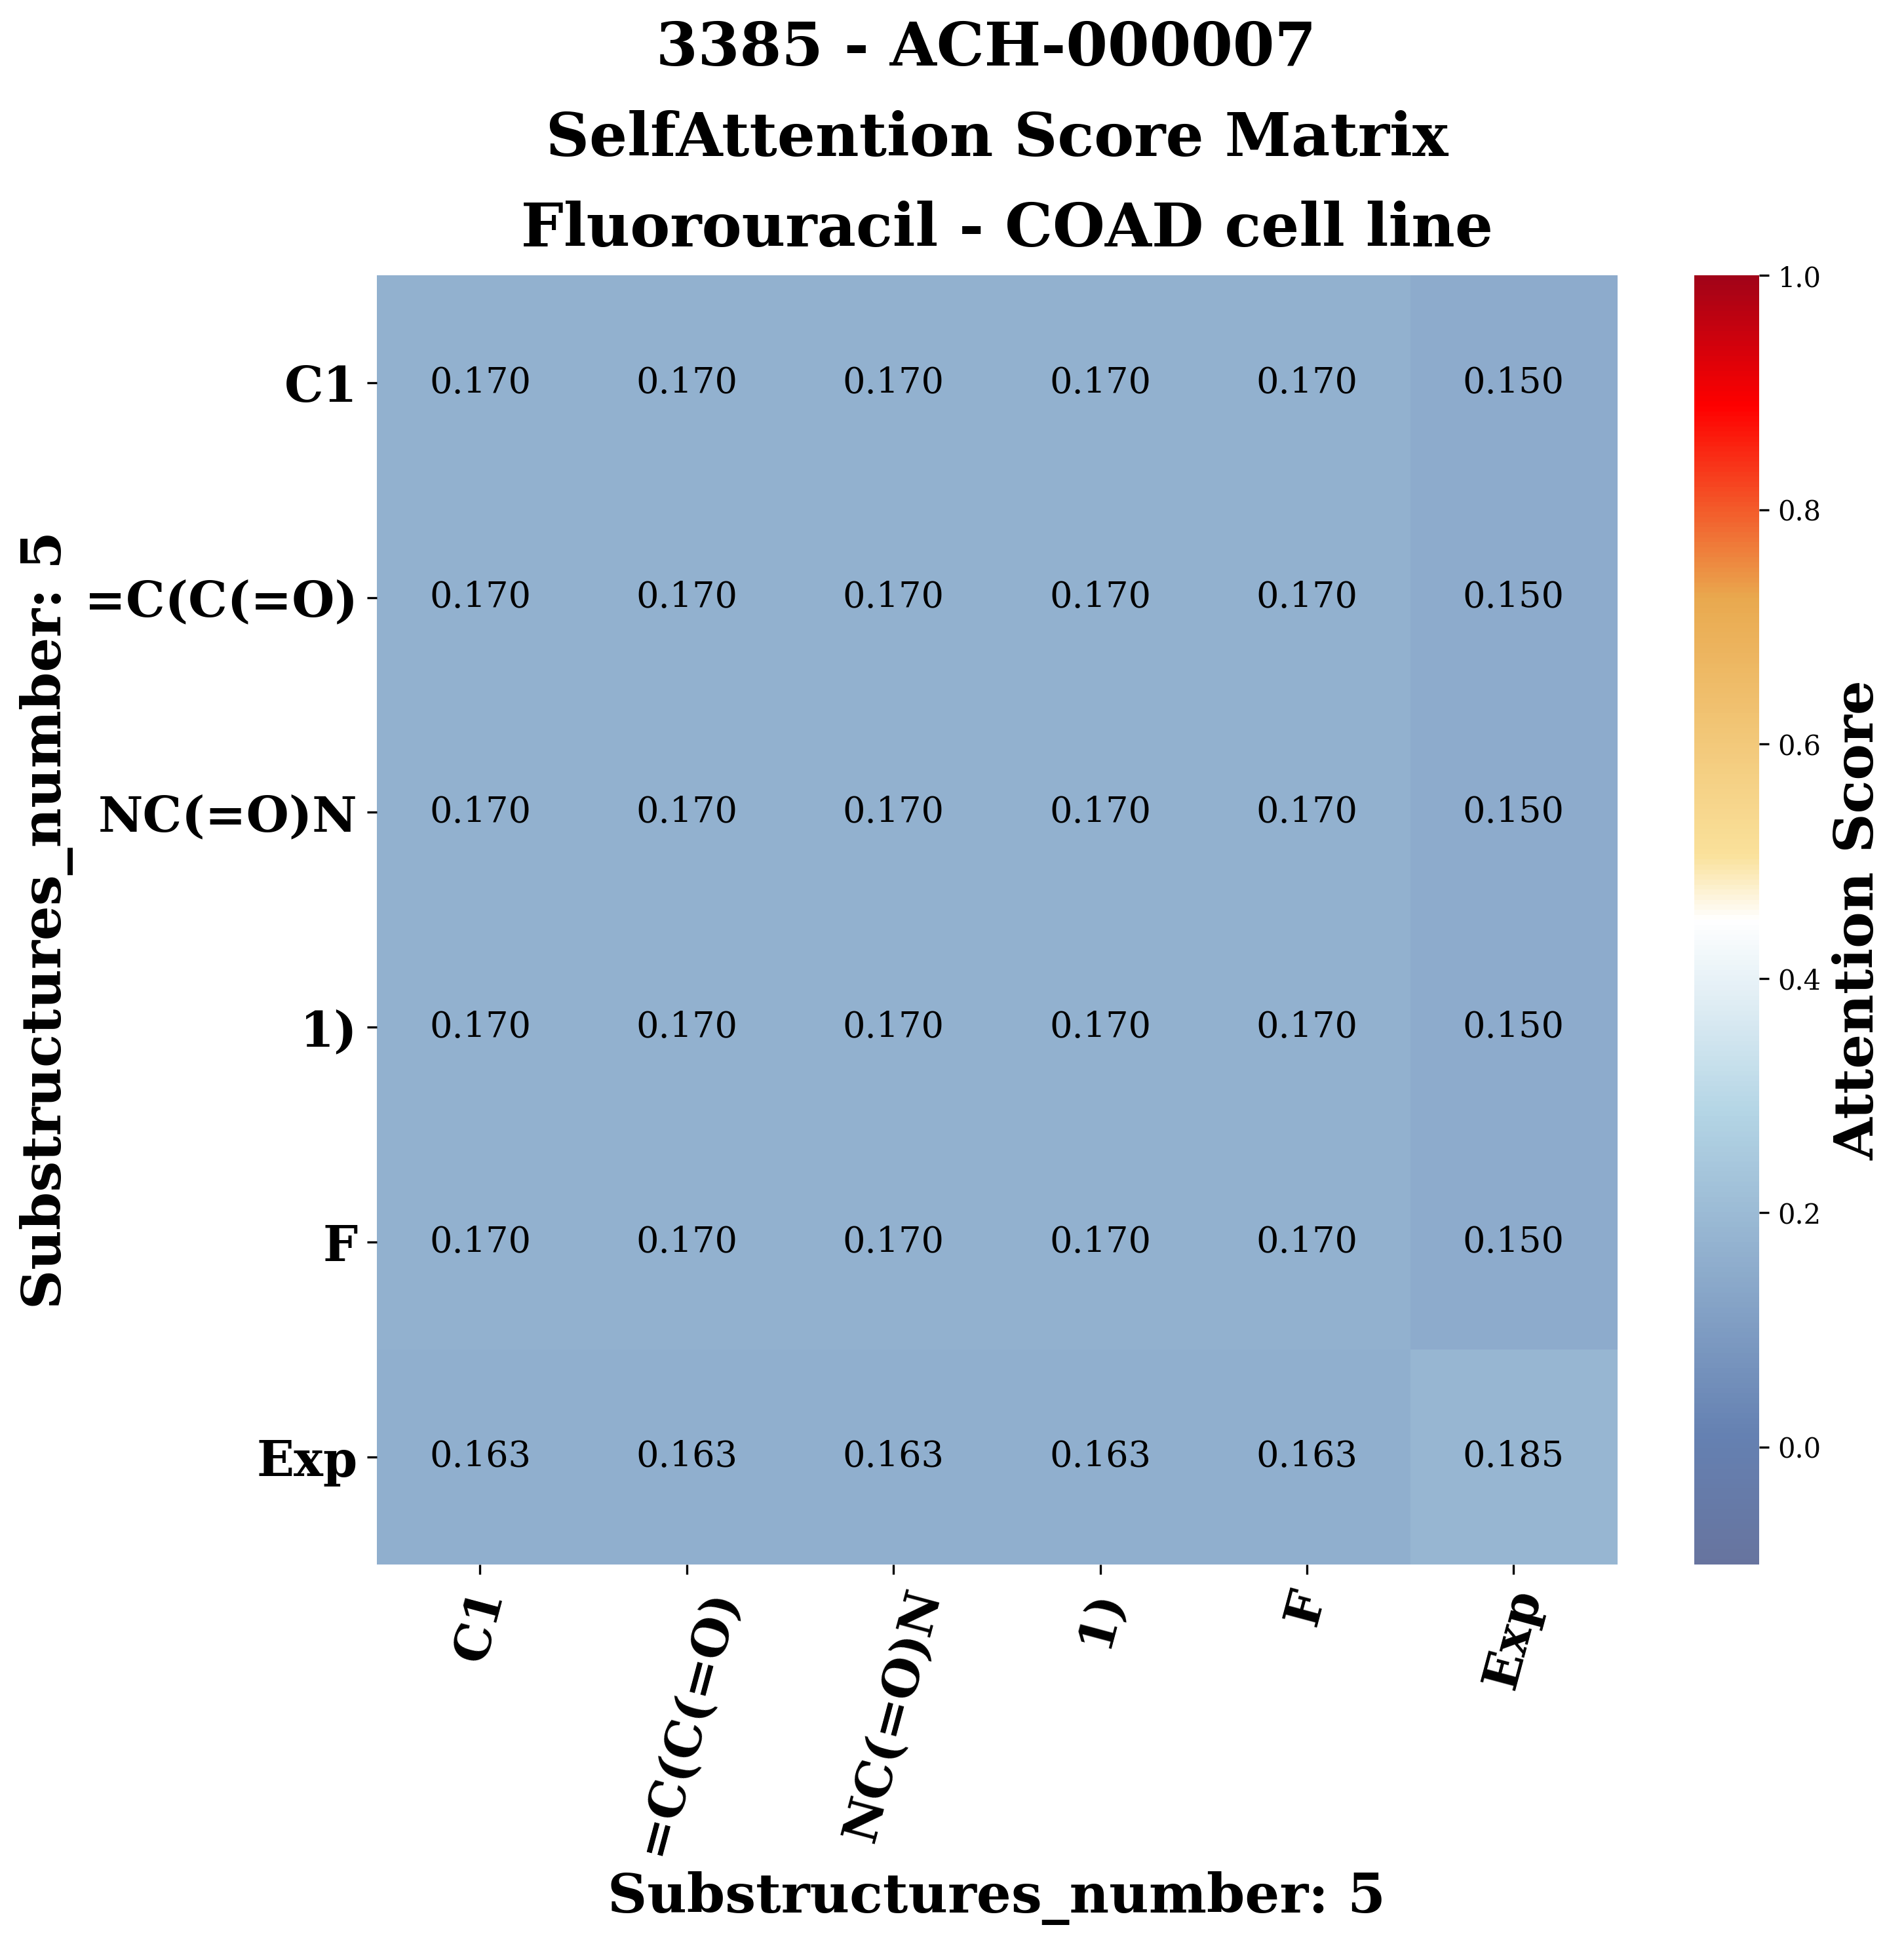

In [35]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugCellSelf[~torch.all(AttenScorMat_DrugCellSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugCellSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugCellSelf_dropnan.shape)
heatmap(AttenScorMat_DrugCellSelf_dropnan.cpu(), drug_ID, cell_ID,drug_name_short,ccl_type, include_omics, fontsize_ticks=18, module="AttenScorMat_DrugCellSelf", sub= drug_encode.values[0][2])

In [36]:
top2 = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",","sub", max_x+1)
if max_y+1 > len(drug_encode.values[0][2]) and max_x+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
elif max_y+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
elif max_x+1 > len(drug_encode.values[0][2]):   
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
else:
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)

if  sec_max_y+1 > len(drug_encode.values[0][2]) and sec_max_x+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
elif sec_max_y+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )
elif sec_max_x+1 > len(drug_encode.values[0][2]):   
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
else:
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_y] )
# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [35, 0] 
 score values: [0.18524563312530518, 0.16992023587226868]
max score matrix index pair: sub 6 , sub 6
max score matrix index pair y-axis: Exp
max score matrix index pair x-axis: Exp
sec_max score matrix index pair: sub 1 , sub 1
sec_max score matrix index pair y-axis: C1
sec_max score matrix index pair x-axis: C1


In [ ]:
def interpret_indices(y, x, drug_subunits, omics_names):
    len_drug = len(drug_subunits)
    if y >= len_drug and x >= len_drug:
        y_label = omics_names[y - len_drug]
        x_label = omics_names[x - len_drug]
    elif y >= len_drug:
        y_label = omics_names[y - len_drug]
        x_label = drug_subunits[x]
    elif x >= len_drug:
        y_label = drug_subunits[y]
        x_label = omics_names[x - len_drug]
    else:
        y_label = drug_subunits[y]
        x_label = drug_subunits[x]
    return y_label, x_label
# Flatten and sort
top3_vals, top3_indices = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)
top3_vals = top3_vals[:3]
top3_indices = top3_indices[:3]
print("Top 3 indices of flattened score matrix:", top3_indices.tolist())
print("Score values:", top3_vals.tolist())
# Get dimensions
n_cols = AttenScorMat_DrugCellSelf_dropnan.shape[1]
drug_subunits = drug_encode.values[0][2]
# Process top-1
y1, x1 = divmod(top3_indices[0].item(), n_cols)
label_y1, label_x1 = interpret_indices(y1, x1, drug_subunits, include_omics)
print(f"Max score index pair: sub{y1+1}, sub{x1+1}")
print("→ y-axis:", label_y1)
print("→ x-axis:", label_x1)
# Process top-2
y2, x2 = divmod(top3_indices[1].item(), n_cols)
label_y2, label_x2 = interpret_indices(y2, x2, drug_subunits, include_omics)
print(f"Second max score index pair: sub{y2+1}, sub{x2+1}")
print("→ y-axis:", label_y2)
print("→ x-axis:", label_x2)
# Process top-3
y3, x3 = divmod(top3_indices[2].item(), n_cols)
label_y3, label_x3 = interpret_indices(y3, x3, drug_subunits, include_omics)
print(f"Second max score index pair: sub{y3+1}, sub{x3+1}")
print("→ y-axis:", label_y3)
print("→ x-axis:", label_x3)

Top 3 indices of flattened score matrix: [35, 0, 1]
Score values: [0.18524563312530518, 0.16992023587226868, 0.16992023587226868]
Max score index pair: sub6, sub6
→ y-axis: Exp
→ x-axis: Exp
Second max score index pair: sub1, sub1
→ y-axis: C1
→ x-axis: C1
Second max score index pair: sub1, sub2
→ y-axis: C1
→ x-axis: =C(C(=O)


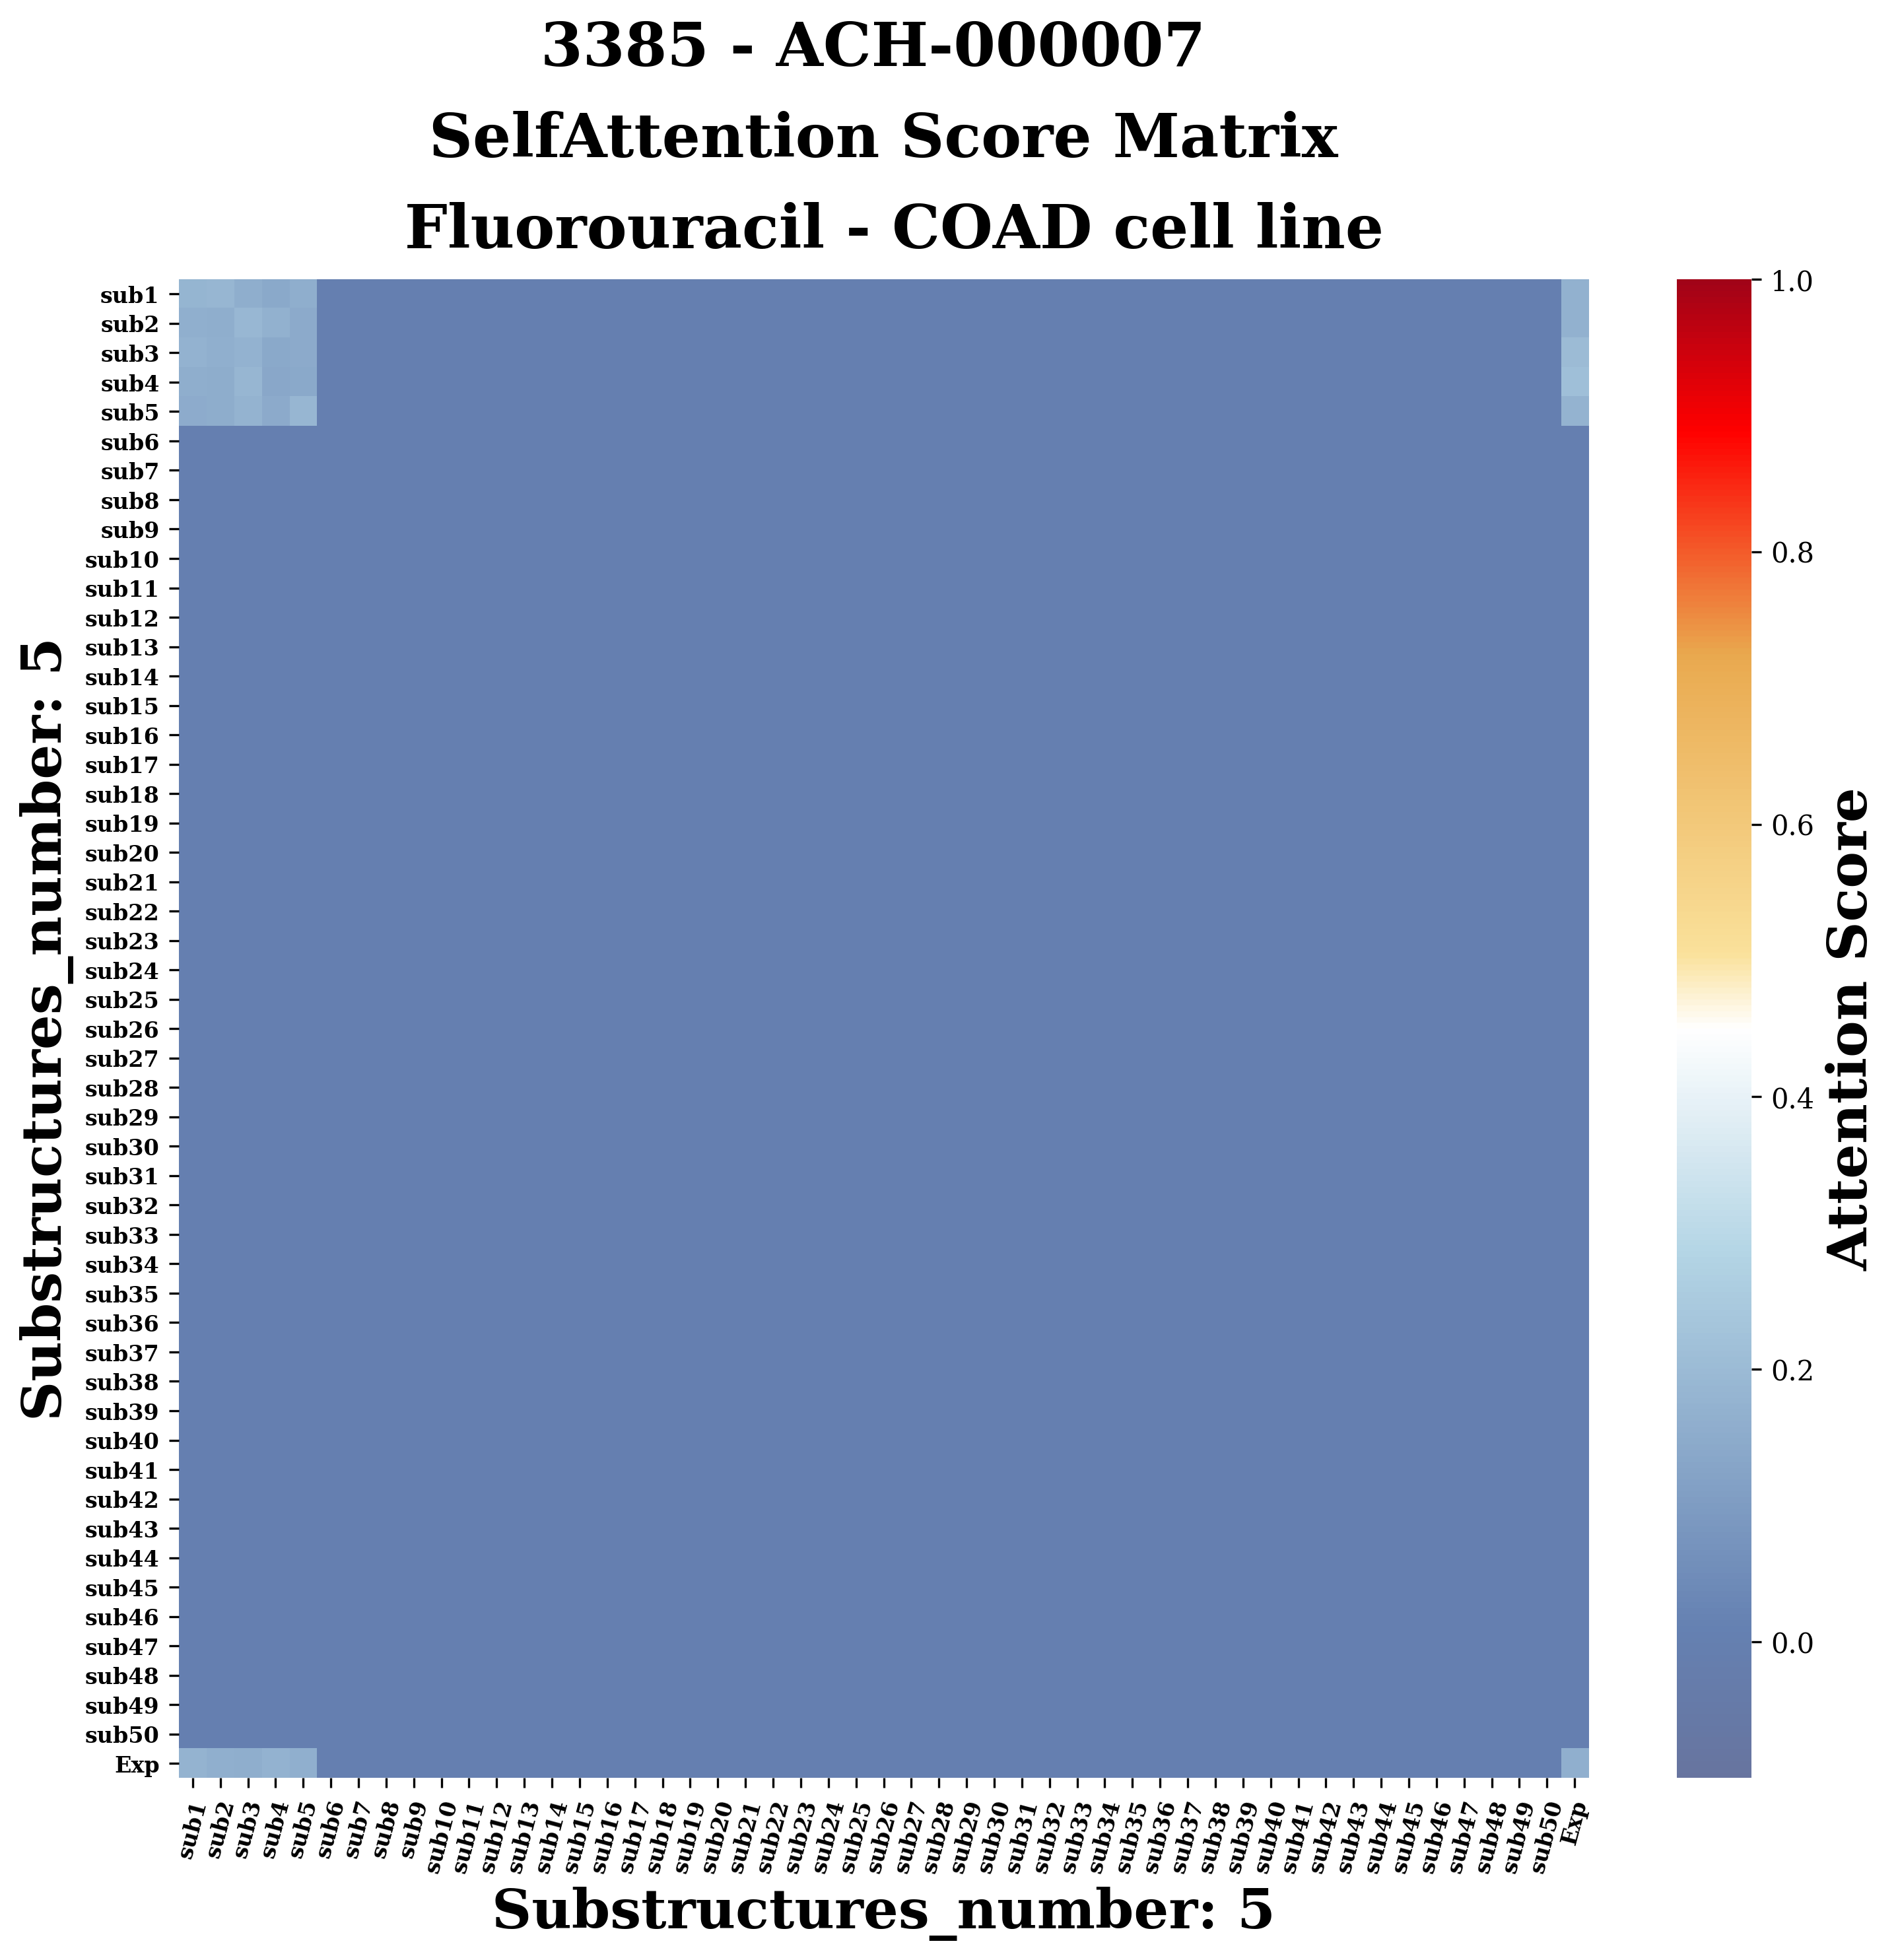

In [103]:
heatmap(AttenScorMat_DrugCellSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugCellSelf")

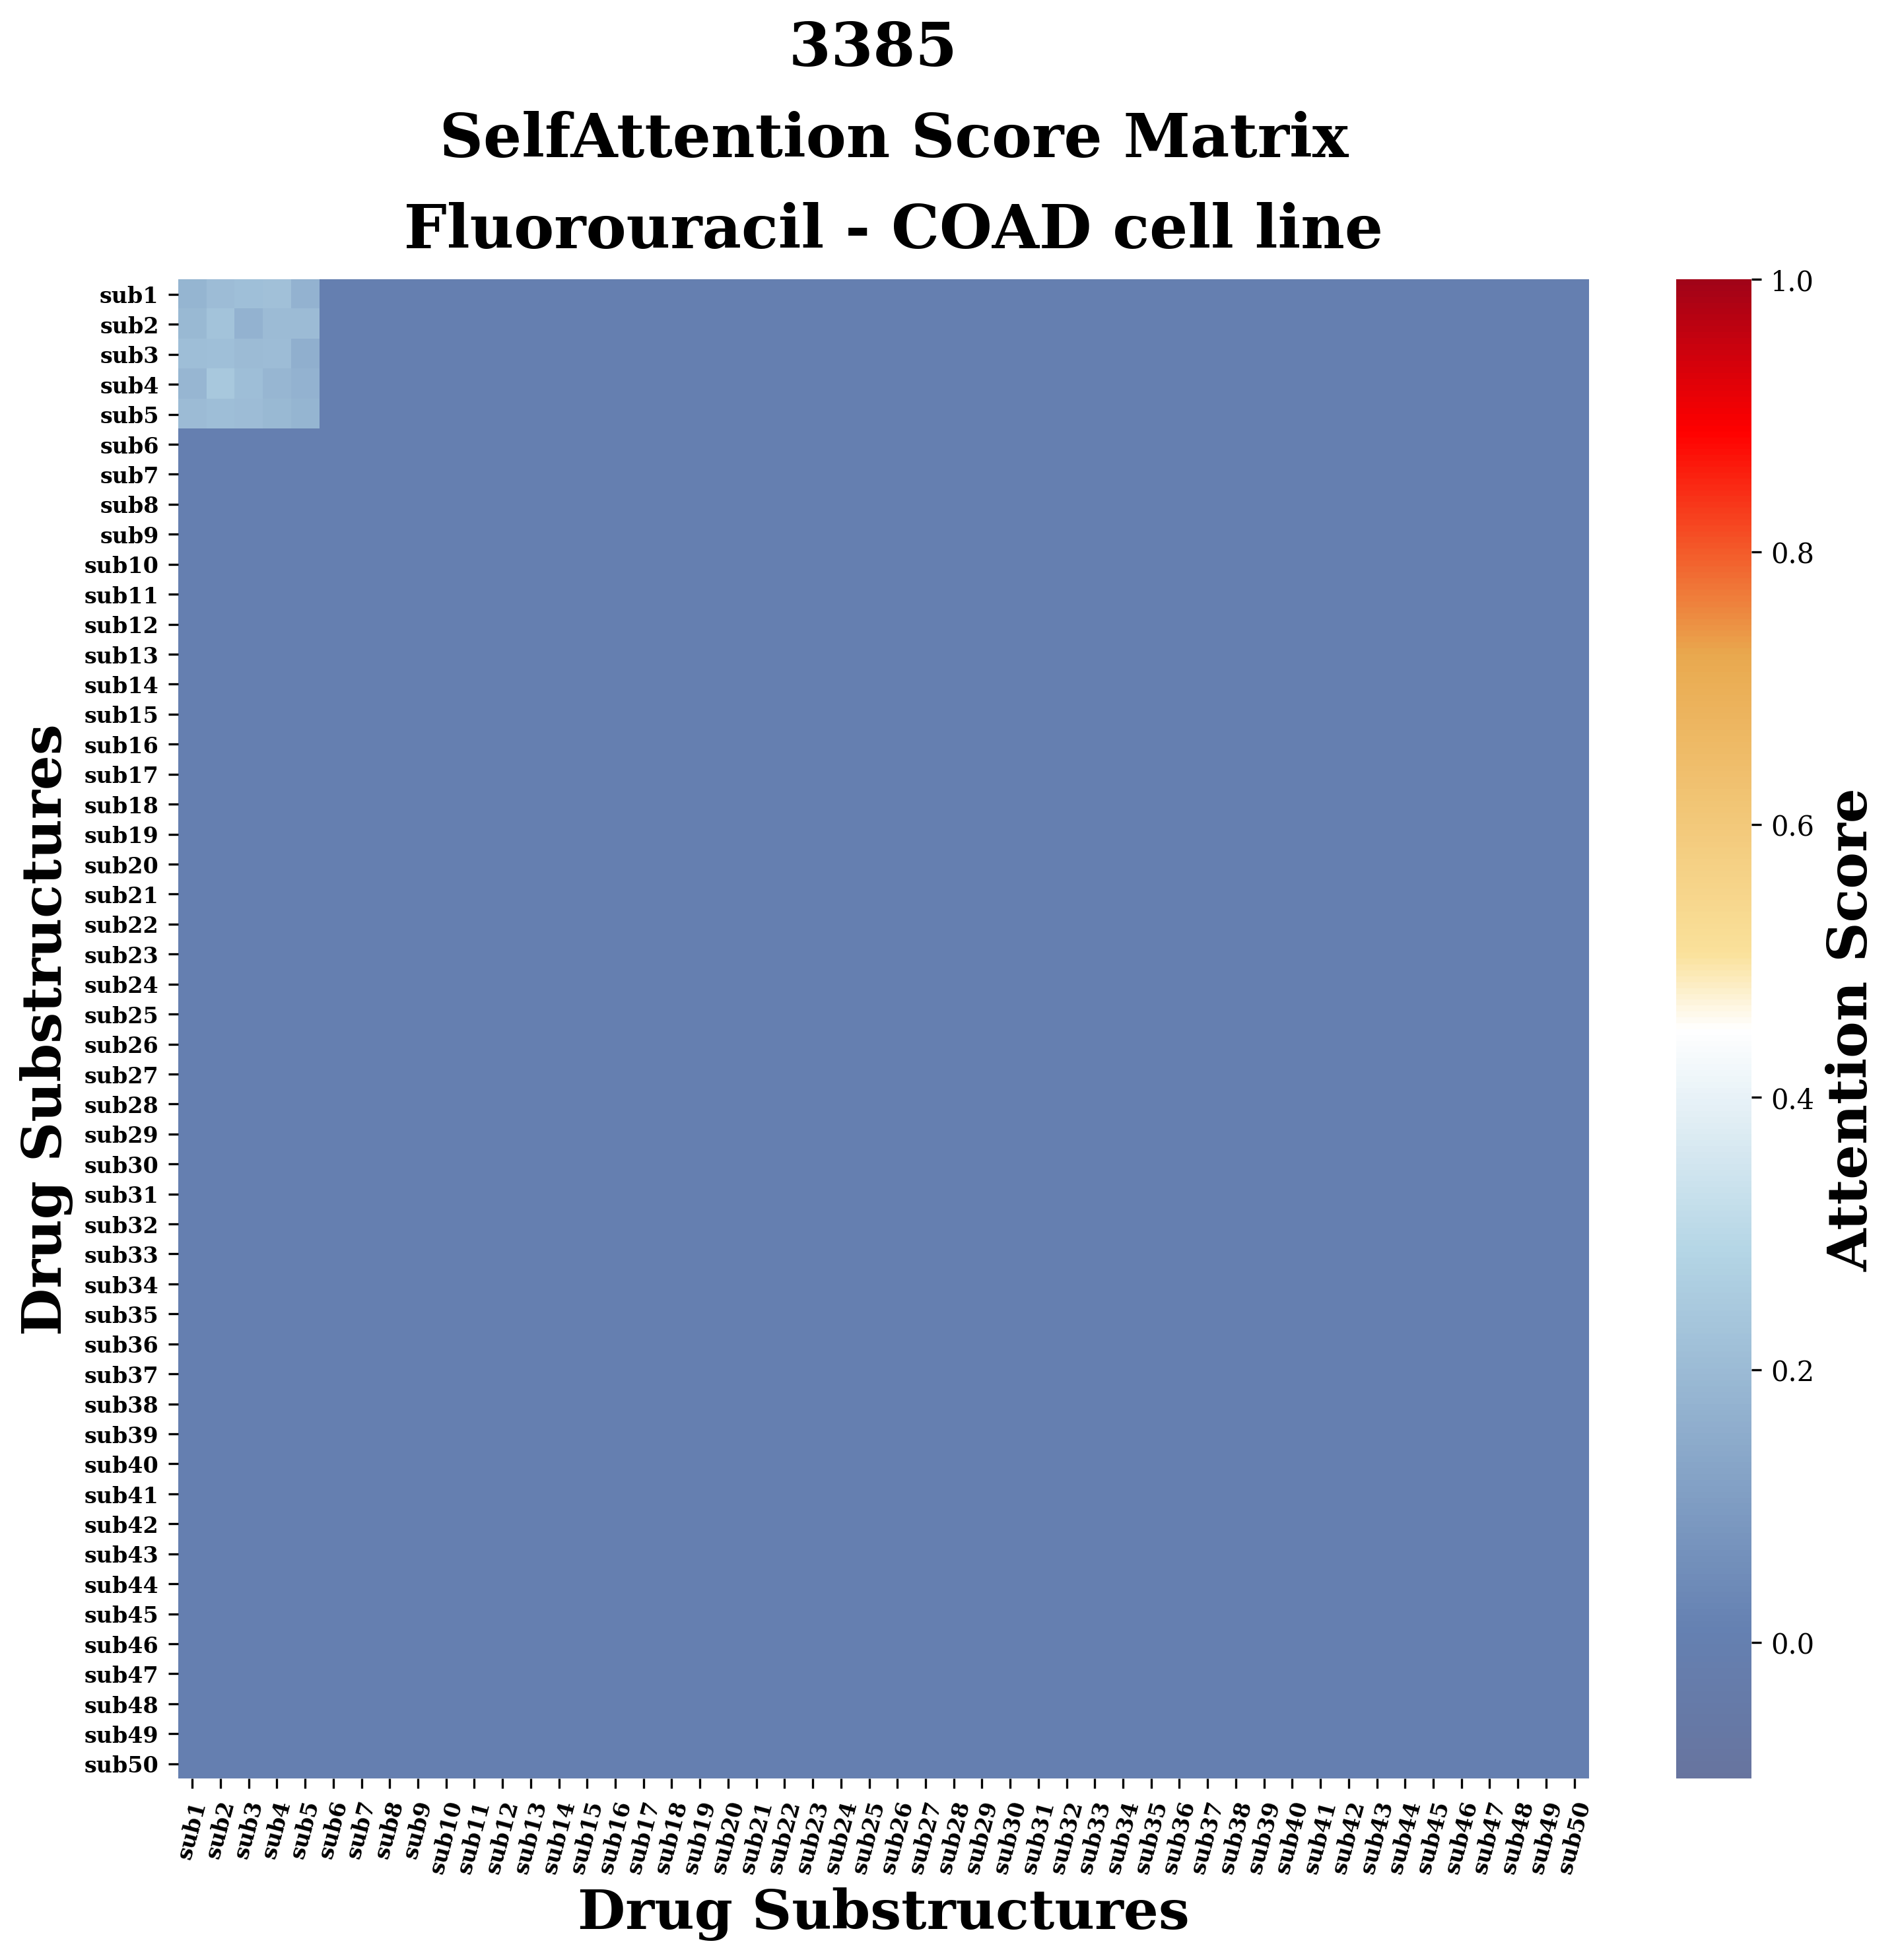

In [104]:
heatmap(AttenScorMat_DrugSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugSelf" )